In [1]:
!wandb login  10399f661a235ae82bbb4e38bf82f1d680bc08c5

wandb: Appending key for api.wandb.ai to your netrc file: /Users/scott/.netrc


In [2]:
import wandb
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

In [3]:
from serotonin4d import run_one

In [4]:

api = wandb.Api()

# Project is specified by <entity/project-name>
runs = api.runs("linderman-lab/serotonin-tucker-decomp-4d")

summary_list, config_list, name_list = [], [], []
for run in runs:
    # .summary contains the output keys/values for metrics like accuracy.
    #  We call ._json_dict to omit large files
    summary_list.append(run.summary._json_dict)

    # .config contains the hyperparameters.
    #  We remove special values that start with _.
    config_list.append(
        {k: v for k,v in run.config.items()
          if not k.startswith('_')})

    # .name is the human-readable name of the run.
    name_list.append(run.name)

runs_df = pd.DataFrame({
    "summary": summary_list,
    "config": config_list,
    "name": name_list
    })

runs_df.to_csv("project.csv")

In [5]:
runs_df

,summary,config,name
0,"{'_wandb': {'runtime': 1077}, 'acc_std': 0.017...","{'K_M': 24, 'K_N': 4, 'K_P': 2, 'K_S': 24, 'to...",lemon-elevator-1577
1,"{'pct_dev_mean': 0.34353381395339966, '_wandb'...","{'K_M': 24, 'K_N': 4, 'K_P': 2, 'K_S': 22, 'to...",magic-oath-1576
2,"{'acc_mean': 0.4347949922084808, 'pct_dev_std'...","{'K_M': 24, 'K_N': 4, 'K_P': 2, 'K_S': 20, 'to...",wobbly-cosmos-1575
3,"{'_wandb': {'runtime': 933}, 'acc_std': 0.0096...","{'K_M': 24, 'K_N': 4, 'K_P': 2, 'K_S': 18, 'to...",silver-durian-1574
4,"{'_wandb': {'runtime': 577}, 'acc_std': 0.0133...","{'K_M': 24, 'K_N': 4, 'K_P': 2, 'K_S': 16, 'to...",devout-jazz-1573
...,...,...,...
1565,"{'pct_dev_std': 0.00025335056125186384, 'pct_d...","{'K_M': 2, 'K_N': 2, 'K_P': 2, 'K_S': 10, 'tol...",warm-frost-11
1566,"{'_wandb': {'runtime': 15}, 'acc_std': 0, 'acc...","{'K_M': 2, 'K_N': 2, 'K_P': 2, 'K_S': 8, 'tol'...",ethereal-snowflake-10
1567,"{'_wandb': {'runtime': 17}, 'acc_std': 0.00235...","{'K_M': 2, 'K_N': 2, 'K_P': 2, 'K_S': 6, 'tol'...",denim-forest-9
1568,"{'_wandb': {'runtime': 16}, 'acc_std': 0, 'acc...","{'K_M': 2, 'K_N': 2, 'K_P': 2, 'K_S': 4, 'tol'...",polar-puddle-8


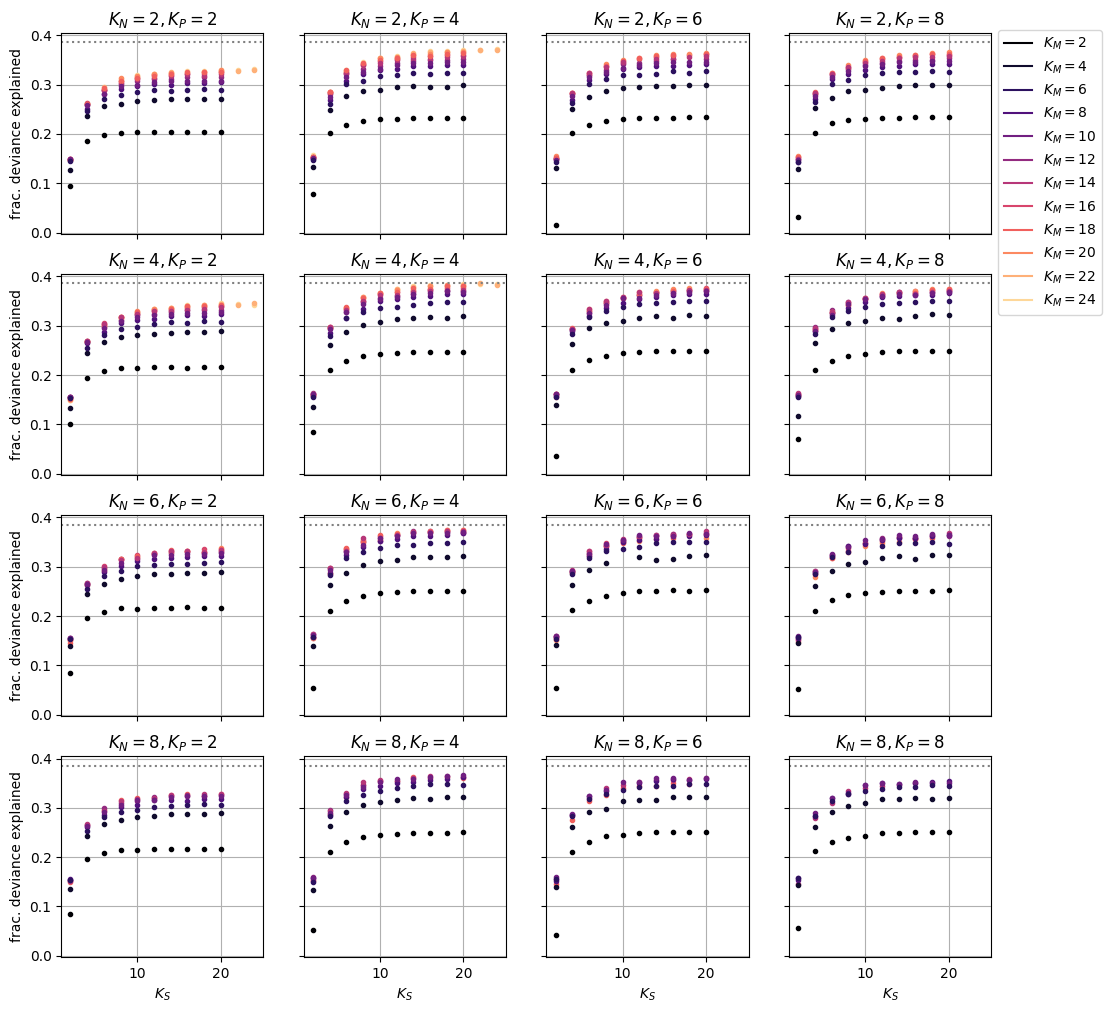

In [6]:
fig, axs = plt.subplots(4, 4, sharey=True, sharex=True, figsize=(12, 12))

from matplotlib.cm import magma as cmap

best_pct_dev = -np.inf

K_M_max = 24
K_N_max = 8
K_P_max = 8

for index, row in runs_df.iterrows():
    if 'pct_dev_mean' not in row['summary']:
        continue

    try:
        K_M = int(row['config']['K_M'])
        K_N = int(row['config']['K_N'])
        K_P = int(row['config']['K_P'])
        K_S = int(row['config']['K_S'])

        # if K_M > K_M_max:
        #     continue

        pct_dev = row['summary']['pct_dev_mean']
        pct_dev_std = row['summary']['pct_dev_std']
        if pct_dev > best_pct_dev:
            best_pct_dev = pct_dev

        ax = axs[(K_N - 2) // 2, (K_P - 2) // 2]
        color = cmap((K_M - 2) / K_M_max)
        ax.plot(K_S, pct_dev, marker='.', markersize=6, color=color)
        # ax.errorbar(np.array([K_S]),
        #             np.array([pct_dev]),
        #             yerr=2 * np.array([pct_dev_std]) / np.sqrt(10),
        #             color=color, lw=3)

    except Exception as e:
        raise e

# Make a dummy legend
for K_M in range(2, K_M_max+1, 2):
    color = cmap((K_M - 2) / K_M_max)
    axs[0, -1].plot([], [], color=color, label=r"$K_M={}$".format(K_M))
axs[0, -1].legend(bbox_to_anchor=(1, 0, 0, 1.05))

# for ax, K_N in zip(axs, np.arange(2, K_N_max+1, 2)):
for i, K_N in enumerate(np.arange(2, K_N_max+1, 2)):
    for j, K_P in enumerate(np.arange(2, K_N_max+1, 2)):
        axs[i,j].set_title(r"$K_N={}, K_P={}$".format(K_N, K_P))
        axs[i,j].axhline(best_pct_dev, ls=':', color='grey')
        axs[i,j].grid(True)

for i in range(4):
    axs[i, 0].set_ylabel("frac. deviance explained")

for j in range(4):
    axs[-1, j].set_xlabel(r"$K_S$")

## Fit the best model

In [7]:
model, params, lps, acc, confusion_matrix = run_one(
    data_dir="/Users/scott/Dropbox/Data/serotonin",
    seed=0, 
    km=22,
    kn=4,
    kp=4,
    ks=22,
    alpha=1.1,
    num_iters=2000,
    train_frac=1.0,
)

initializing model
done


  0%|          | 0/2000 [00:00<?, ?it/s]